In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init
import sys

sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel

## Load and process the data

In [2]:
df_purebkg = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_background.h5")

In [3]:
columns = df_purebkg.columns

In [4]:
columns[[4,5,6,7,8,11,12,20,21,22,23,24,27,28]]

Index(['j1 tau21', 'j1 tau32', 'j1 tau43', 'j1 tau54', 'j1 tau65',
       'j1 sqrt(tau^2_1)/tau^1_1', 'j1 n_trk', 'j2 tau21', 'j2 tau32',
       'j2 tau43', 'j2 tau54', 'j2 tau65', 'j2 sqrt(tau^2_1)/tau^1_1',
       'j2 n_trk'],
      dtype='object')

In [5]:
dt = df_purebkg.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0) &(dt[:,2]>0) & (dt[:,16]>0) & (dt[:,32]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])


correct = (dt[:,16]>0) & (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]
correct = (dt[:,3]>100)
dt = dt[correct]

correct = (dt[:,19]>20)
dt = dt[correct]

correct = (dt[:,0]>=2800)
dt = dt[correct]

#bsmlike = np.where(dt[:,16]>0.9)[0]
#dt = dt[bsmlike]
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]] 




In [6]:
dt.shape

(403661, 35)

In [7]:
j1sdb = dt[:,3]*dt[:,16]
j2sdb = dt[:,19]*dt[:,32]

pt = dt[:,1]
m = j1sdb[:]
m2 = j2sdb[:]
tau21 = dt[:,4]
tau32 = dt[:,5]
tau43 = dt[:,6]
tau54 = dt[:,7]
tau65 = dt[:,8]
massratio = dt[:,16]

rho = np.log((m*m)/(pt*pt))
rhoprime = np.log((m*m)/(pt*1))

tau21prime = tau21 + rhoprime * 0.088
tau32prime = tau32 + rhoprime * 0.025
tau43prime = tau43 + rhoprime * 0.01
tau54prime = tau54 + rhoprime * 0.001

j2pt = dt[:,2]
#m = j1sdb[mrange]
j2m = j2sdb[:]
j2tau21 = dt[:,20]
j2tau32 = dt[:,21]
j2tau43 = dt[:,22]
j2tau54 = dt[:,23]
j2tau65 = dt[:,24]
j2massratio = dt[:,32]


j2rho = np.log((j2m*j2m)/(j2pt*j2pt))
j2rhoprime = np.log((j2m*j2m)/(j2pt*1))

j2tau21prime = j2tau21 + j2rhoprime * 0.086
j2tau32prime = j2tau32 + j2rhoprime * 0.025
j2tau43prime = j2tau43 + j2rhoprime * 0.01
j2tau54prime = j2tau54 + j2rhoprime * 0.001

[1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75 5.25]
0.7653867510684456 -0.00037175802276781435


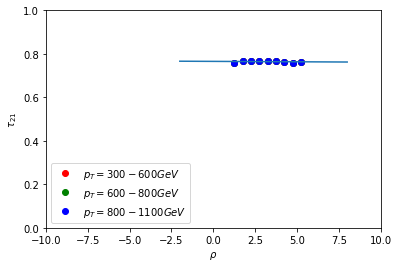

In [8]:
bins = np.arange(1,6,.5)
bincenters = 0.5*(bins[1:]+bins[:-1])
y1 = []
y2 = []
y3 = []
for i in range(len(bins)-1):
    rho_range_mask_1 = (rhoprime > bins[i]) & (rhoprime < bins[i+1]) & (pt>0) & (pt<3000)
    rho_range_mask_2 = (rhoprime > bins[i]) & (rhoprime < bins[i+1]) & (pt>0) & (pt<3000) #& (dt[mrange,32]<0.5)
    rho_range_mask_3 = (rhoprime > bins[i]) & (rhoprime < bins[i+1]) & (pt>0) & (pt<3000) #& (dt[mrange,32]>0.9)
    #print(tau21[rho_range_mask_1])
    y1.append(np.average(tau21prime[rho_range_mask_1]))
    y2.append(np.average(tau21prime[rho_range_mask_2]))
    y3.append(np.average(tau21prime[rho_range_mask_3]))

print(bincenters)
plt.xlim(-10,10)
plt.ylim(0,1)
slope,b = np.polyfit(bincenters[:],y2[:],1) 
print(b,slope)
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\tau_{21}$')
plt.plot(bincenters,y1,color='r',marker='o',linestyle='None',label=r'$p_{T} = 300-600 GeV$')
plt.plot(bincenters,y2,color='g',marker='o',linestyle='None',label=r'$p_{T} = 600-800 GeV$')
plt.plot(bincenters,y3,color='b',marker='o',linestyle='None',label=r'$p_{T} = 800-1100 GeV$')
plt.legend()
fitx = np.linspace(-2,8,100)
plt.plot(fitx,b+slope*fitx, '-', label=f'fit function: slope {slope:.3f}')
#plt.savefig('tau21avg_rho_plot.png')
#plt.savefig('tau21avg_rho_plot.pdf')

[2.25 2.75 3.25 3.75 4.25 4.75 5.25]
0.760161018853051 0.00021429891821758424


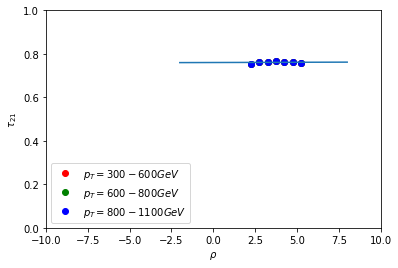

In [9]:
bins = np.arange(2,6,.5)
bincenters = 0.5*(bins[1:]+bins[:-1])
y1 = []
y2 = []
y3 = []
for i in range(len(bins)-1):
    rho_range_mask_1 = (j2rhoprime > bins[i]) & (j2rhoprime < bins[i+1]) & (j2pt>0) & (j2pt<3000)
    rho_range_mask_2 = (j2rhoprime > bins[i]) & (j2rhoprime < bins[i+1]) & (j2pt>0) & (j2pt<3000) #& (dt[mrange,32]<0.5)
    rho_range_mask_3 = (j2rhoprime > bins[i]) & (j2rhoprime < bins[i+1]) & (j2pt>0) & (j2pt<3000) #& (dt[mrange,32]>0.9)
    #print(tau21[rho_range_mask_1])
    y1.append(np.average(j2tau21prime[rho_range_mask_1]))
    y2.append(np.average(j2tau21prime[rho_range_mask_2]))
    y3.append(np.average(j2tau21prime[rho_range_mask_3]))

print(bincenters)
plt.xlim(-10,10)
plt.ylim(0,1)
slope,b = np.polyfit(bincenters[:],y2[:],1) 
print(b,slope)
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\tau_{21}$')
plt.plot(bincenters,y1,color='r',marker='o',linestyle='None',label=r'$p_{T} = 300-600 GeV$')
plt.plot(bincenters,y2,color='g',marker='o',linestyle='None',label=r'$p_{T} = 600-800 GeV$')
plt.plot(bincenters,y3,color='b',marker='o',linestyle='None',label=r'$p_{T} = 800-1100 GeV$')
plt.legend()
fitx = np.linspace(-2,8,100)
plt.plot(fitx,b+slope*fitx, '-', label=f'fit function: slope {slope:.3f}')
#plt.savefig('tau21avg_rho_plot.png')
#plt.savefig('tau21avg_rho_plot.pdf')
                 

In [10]:
dt[:,4] = tau21prime
dt[:,5] = tau32prime
dt[:,6] = tau43prime
dt[:,7] = tau54prime

dt[:,20] = j2tau21prime 
dt[:,21] = j2tau32prime
dt[:,22] = j2tau43prime
dt[:,23] = j2tau54prime

In [11]:
columns[19]

'Mj2'

In [12]:
m1minusm2 = dt[:,3] - dt[:,19] 

dt[:,19] = m1minusm2

In [14]:
Y = dt[:,[3,4,5,6,7,8,11,12,19,20,21,22,23,24,27,28]]

In [15]:
Y.shape

(403661, 16)

In [16]:
    
#if whichbkg == 'rndbkg':
#    dt = df_rndbkg.values
#    correct = (dt[:,3]>0) &(dt[:,19]>0) &(dt[:,1]>0) &(dt[:,2]>0)&(dt[:,16]>0)&(dt[:,32]>0)
#    dt = dt[correct]
#    for i in range(13,19):
#        dt[:,i] = dt[:,i]/dt[:,3]
#    
#    for i in range(29,35):
#        dt[:,i] = dt[:,i]/(dt[:,19])
#        
#    correct = (dt[:,16]>0) &(dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
#    dt = dt[correct]   
#    correct = (dt[:,0]>=2800)
#    dt = dt[correct]
#    #Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#    idx = dt[:,-1]
#    bkg_idx = np.where(idx==0)[0]
#    signal_idx = np.where(idx==1)[0]
#    dt = dt[bkg_idx]
#    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
#    Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]

In [17]:
bkg_mean = []
bkg_std = []

In [18]:
for i in range(16):
    mean = np.mean(Y[:,i])
    std = np.std(Y[:,i])
    bkg_mean.append(mean)
    bkg_std.append(std)
    Y[:,i] = (Y[:,i]-mean)/std

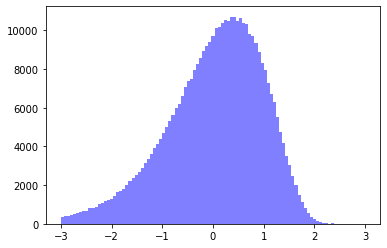

In [19]:
bins = np.linspace(-3,3,100)
bins.shape
column = 4
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(Y[:,column],bins,alpha=0.5,color='b');
#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

In [20]:
bkg_mean

[256.61676365669723,
 0.7412184019985449,
 0.7725036016006919,
 0.8291300771565643,
 0.8527037193169963,
 0.8765286261584321,
 1.8447703489660499,
 276.5763350930608,
 144.52937998756502,
 0.6502153813116346,
 0.7547505196911458,
 0.8105667352562749,
 0.8362211210770141,
 0.8523954226694409,
 2.3528028777209804,
 170.64564572747923]

In [21]:
bkg_std

[126.0192431426296,
 0.16734130209515913,
 0.1299489260827339,
 0.08799701015618867,
 0.06259243191236713,
 0.04920989922433026,
 0.6900987268970455,
 106.3501675825008,
 116.33233171384133,
 0.18586798991448034,
 0.11643367298982578,
 0.08560677158442588,
 0.06894948002860742,
 0.06405717872037334,
 1.0377565821718762,
 85.68173285417313]

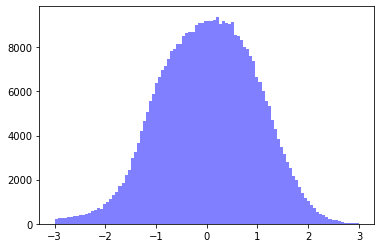

In [22]:
bins = np.linspace(-3,3,101)
plt.hist(Y[:,1],bins,alpha=0.5,color='b');

In [23]:
total_PureBkg = torch.tensor(Y)

total_PureBkg_selection = total_PureBkg

In [24]:
total_PureBkg_selection.shape

torch.Size([403661, 16])

In [25]:
bs = 800
bkgAE_train_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs, shuffle=True) 
bkgAE_test_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs)

## Build the model

In [26]:
####MAF 
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(16, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 48),
            nn.LeakyReLU(True),            
            nn.Linear(48, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 48),
            nn.LeakyReLU(True),
            nn.Linear(48, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 16)
        )
        
        flow_init = MAF(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

## Creating Instance¶

In [27]:
N_EPOCHS = 30
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

N_FLOWS = 10
Z_DIM = 6

n_steps = 0

In [28]:
model = VAE_NF(N_FLOWS, Z_DIM).cuda()

In [29]:
optimizer = optim.Adam(model.parameters(), lr=1e-6)

In [30]:
beta = 1

In [31]:
def train():
    global n_steps
    train_loss = []
    model.train()

    for batch_idx, x in enumerate(bkgAE_train_iterator):
        start_time = time.time()
        
        x = x.float().cuda()

        x_tilde, kl_div = model(x)
        
        
        
        mseloss = nn.MSELoss(size_average=False)
        
        huberloss = nn.SmoothL1Loss(size_average=False)
        

        #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
        loss_recons = mseloss(x_tilde,x ) / x.size(0)
        
        #loss_recons = huberloss(x_tilde,x ) / x.size(0)
        loss = loss_recons + beta * kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append([loss_recons.item(), kl_div.item()])

        if (batch_idx + 1) % PRINT_INTERVAL == 0:
            print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch'.format(
                batch_idx * len(x), 50000,
                PRINT_INTERVAL * batch_idx / 50000,
                np.asarray(train_loss)[-PRINT_INTERVAL:].mean(0),
                1000 * (time.time() - start_time)
            ))

        n_steps += 1

In [32]:
def evaluate(split='valid'):
    global n_steps
    start_time = time.time()
    val_loss = []
    model.eval()

    with torch.no_grad():
        for batch_idx, x in enumerate(bkgAE_test_iterator):
            
            x = x.float().cuda()

            x_tilde, kl_div = model(x)
            mseloss = nn.MSELoss(size_average=False)
            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            huberloss = nn.SmoothL1Loss(size_average=False)
        

            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            loss_recons = mseloss(x_tilde,x ) / x.size(0)
            #loss_recons = huberloss(x_tilde,x ) / x.size(0)
            loss = loss_recons + beta * kl_div

            val_loss.append(loss.item())
            #writer.add_scalar('loss/{}/ELBO'.format(split), loss.item(), n_steps)
            #writer.add_scalar('loss/{}/reconstruction'.format(split), loss_recons.item(), n_steps)
            #writer.add_scalar('loss/{}/KL'.format(split), kl_div.item(), n_steps)

    print('\nEvaluation Completed ({})!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
        split,
        np.asarray(val_loss).mean(0),
        time.time() - start_time
    ))
    return np.asarray(val_loss).mean(0)

In [33]:
print(beta)

1


In [54]:
print(model)

VAE_NF(
  (encoder): Sequential(
    (0): Linear(in_features=16, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=50, out_features=48, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=48, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=48, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=48, out_features=50, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=50, out_features=16, bias=True)
  )
  (flows): NormalizingFlowModel(
    (flows): ModuleList(
      (0): MAF(
        (layers): ModuleList(
          (0): FCNN(
            (network): Sequential(
              (0): Linear(in_features=1, out_features=8, bias=True)
              (1): Tanh()
              (2): Linear(in_features=8, out_features=8, bias=True)
              (3): Tanh()
              (4): Linear(in_features=8, out_features=2, bias=True)

In [35]:
'''
ae_def = {
    "type":"bkg",
    "trainon":"purebkg",
    "features":"tauDDTwithrawmass",
    "architecture":"MAF",
    "selection":"turnoncutandj1sdbcut",
    "trainloss":"MSELoss",
    "beta":"beta1",
    "zdimnflow":"z6f10",
}
'''

'\nae_def = {\n    "type":"bkg",\n    "trainon":"purebkg",\n    "features":"tauDDTwithrawmass",\n    "architecture":"MAF",\n    "selection":"turnoncutandj1sdbcut",\n    "trainloss":"MSELoss",\n    "beta":"beta1",\n    "zdimnflow":"z6f10",\n}\n'

In [53]:
ae_def = {
    "type":"bkg",
    "trainon":"purebkg",
    "features":"tauDDTwithm1andm1minusm2",
    "architecture":"MAF",
    "selection":"turnoncutandj1sdbcut",
    "trainloss":"MSELoss",
    "beta":"beta1",
    "zdimnflow":"z6f10",
}

In [37]:
ae_def

{'type': 'bkg',
 'trainon': 'purebkg',
 'features': 'tauDDTwithm1andm1minusm2',
 'architecture': 'MAF',
 'selection': 'turnoncutandj1sdbcut',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z6f10'}

In [39]:
N_EPOCHS = 10
BEST_LOSS = -57.9867
LAST_SAVED = -1
PATIENCE_COUNT = 0
PATIENCE_LIMIT = 5
for epoch in range(1, 1000):
    print("Epoch {}:".format(epoch))
    train()
    cur_loss = evaluate()

    if cur_loss <= BEST_LOSS:
        PATIENCE_COUNT = 0
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch
        print("Saving model!")
        torch.save(model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5")
    
    else:
        PATIENCE_COUNT += 1
        print("Not saving model! Last saved: {}".format(LAST_SAVED))
        if PATIENCE_COUNT > 10:
            print("Patience Limit Reached")
            break 

Epoch 1:


/home/spark/miniconda3/envs/myenv/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Evaluation Completed (valid)!	Loss: -58.5713 Time: 6.043 s
Saving model!
Epoch 2:

Evaluation Completed (valid)!	Loss: -58.4145 Time: 5.843 s
Not saving model! Last saved: 1
Epoch 3:

Evaluation Completed (valid)!	Loss: -58.0568 Time: 5.851 s
Not saving model! Last saved: 1
Epoch 4:

Evaluation Completed (valid)!	Loss: -58.7380 Time: 5.839 s
Saving model!
Epoch 5:

Evaluation Completed (valid)!	Loss: -58.0144 Time: 5.887 s
Not saving model! Last saved: 4
Epoch 6:

Evaluation Completed (valid)!	Loss: -58.5662 Time: 5.818 s
Not saving model! Last saved: 4
Epoch 7:

Evaluation Completed (valid)!	Loss: -58.5415 Time: 5.871 s
Not saving model! Last saved: 4
Epoch 8:

Evaluation Completed (valid)!	Loss: -58.9572 Time: 5.823 s
Saving model!
Epoch 9:

Evaluation Completed (valid)!	Loss: -58.5966 Time: 5.882 s
Not saving model! Last saved: 8
Epoch 10:

Evaluation Completed (valid)!	Loss: -58.7248 Time: 5.905 s
Not saving model! Last saved: 8
Epoch 11:

Evaluation Completed (valid)!	Loss: -59.2

In [40]:
model.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5"))

<All keys matched successfully>

## Testing the bkg ae

In [57]:
inputlist = [
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_background.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5', 
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5' 
]

In [58]:
ae_def

{'type': 'bkg',
 'trainon': 'purebkg',
 'features': 'tauDDTwithm1andm1minusm2',
 'architecture': 'MAF',
 'selection': 'turnoncutandj1sdbcut',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z6f10'}

In [59]:
outputlist_waic = [
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb1.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb2.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb3.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_purebkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_rndbkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_2prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_3prong.npy",
]

outputlist_justloss = [
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb1.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb2.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb3.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_rndbkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_2prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_3prong.npy",
]

In [60]:
exist_signalflag = [
    False,
    False,
    False,
    False,
    True,
    True,
    True,
]
is_signal = [
    False,
    False,
    False,
    False,
    False,
    True,
    True
]

nprong = [
    None,
    None,
    None,
    None,
    None,
    '2prong',
    '3prong'
]

(239348, 16)
[1.5767106  2.1471012  1.3612453  4.9383464  2.2328825  0.5920955
 2.16843    1.3094869  0.7593274  0.53067166]
(242090, 16)
[1.6664455  1.217134   0.16872102 1.6283345  5.5121207  1.1447091
 1.0923744  1.7390739  1.0051848  2.036542  ]
(231654, 16)
[1.1519064 1.3567827 2.3828826 0.6967716 1.2982614 2.165857  3.2570105
 1.5937437 1.022083  1.1810899]
(232418, 16)
[1.3592188  1.1287769  0.28207487 0.4522487  0.9475181  1.7536566
 1.1640699  3.4202414  1.836065   2.8516896 ]
(263134, 16)
[2.1740108  0.24994242 2.5511372  1.0911618  0.951638   0.78799295
 1.085573   4.2953415  1.6688217  0.99616957]
(55539, 16)
[2.6159606  2.2075045  5.295806   2.3493242  2.1417797  1.0539135
 0.99634993 0.6734415  1.464437   1.7103858 ]
(56525, 16)
[ 0.59636015 49.693077    1.590256    2.0491853   2.7665753   1.7750865
  0.93043697  1.1656888  11.572716    5.1369114 ]


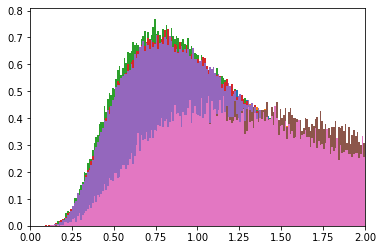

In [61]:
for in_file, out_file_waic, out_file_justloss, sigbit_flag, is_sig, n_prong in zip(inputlist,outputlist_waic,outputlist_justloss,exist_signalflag,is_signal, nprong):    
    
    f_bb = pd.read_hdf(in_file)
    dt = f_bb.values
    correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0) &(dt[:,2]>0) & (dt[:,16]>0) & (dt[:,32]>0)
    dt = dt[correct]
    for i in range(13,19):
        dt[:,i] = dt[:,i]/dt[:,3]

    for i in range(29,35):
        dt[:,i] = dt[:,i]/(dt[:,19])


    correct = (dt[:,16]>0) & (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
    dt = dt[correct]
    correct = (dt[:,3]>100)
    dt = dt[correct]

    correct = (dt[:,19]>20)
    dt = dt[correct]

    correct = (dt[:,0]>=2800)
    dt = dt[correct]

    bsmlike = np.where(dt[:,16]>0.9)[0]
    dt = dt[bsmlike]
    
    j1sdb = dt[:,3]*dt[:,16]
    j2sdb = dt[:,19]*dt[:,32]

    pt = dt[:,1]
    m = j1sdb[:]
    m2 = j2sdb[:]
    tau21 = dt[:,4]
    tau32 = dt[:,5]
    tau43 = dt[:,6]
    tau54 = dt[:,7]
    tau65 = dt[:,8]
    massratio = dt[:,16]

    rho = np.log((m*m)/(pt*pt))
    rhoprime = np.log((m*m)/(pt*1))

    tau21prime = tau21 + rhoprime * 0.088
    tau32prime = tau32 + rhoprime * 0.025
    tau43prime = tau43 + rhoprime * 0.01
    tau54prime = tau54 + rhoprime * 0.001


    j2pt = dt[:,2]
    #m = j1sdb[mrange]
    j2m = j2sdb[:]
    j2tau21 = dt[:,20]
    j2tau32 = dt[:,21]
    j2tau43 = dt[:,22]
    j2tau54 = dt[:,23]
    j2tau65 = dt[:,24]
    j2massratio = dt[:,32]


    j2rho = np.log((j2m*j2m)/(j2pt*j2pt))
    j2rhoprime = np.log((j2m*j2m)/(j2pt*1))

    j2tau21prime = j2tau21 + j2rhoprime * 0.086
    j2tau32prime = j2tau32 + j2rhoprime * 0.025
    j2tau43prime = j2tau43 + j2rhoprime * 0.01
    j2tau54prime = j2tau54 + j2rhoprime * 0.001
    
    dt[:,4] = tau21prime
    dt[:,5] = tau32prime
    dt[:,6] = tau43prime
    dt[:,7] = tau54prime

    dt[:,20] = j2tau21prime 
    dt[:,21] = j2tau32prime
    dt[:,22] = j2tau43prime
    dt[:,23] = j2tau54prime
    
    m1minusm2 = dt[:,3] - dt[:,19] 
    dt[:,19] = m1minusm2
    
    if sigbit_flag:
        idx = dt[:,-1]
        sigidx = (idx == 1)
        bkgidx = (idx == 0)
        if is_sig:
            dt = dt[sigidx]
        else:
            dt = dt[bkgidx]
            
    if n_prong == '2prong':
        correct = dt[:,3] > 300
        dt = dt[correct]
    
    if n_prong == '3prong':
        correct = dt[:,3] > 400
        dt = dt[correct]
            
    
    Y = dt[:,[3,4,5,6,7,8,11,12,19,20,21,22,23,24,27,28]]
    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
    #Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
    

    
            
    print(Y.shape)
    for i in range(16):
        Y[:,i] = (Y[:,i]-bkg_mean[i])/bkg_std[i]
    
    total_bb_test = torch.tensor(Y)
    #huberloss = nn.SmoothL1Loss(reduction='none')
    sigae_bbloss = torch.mean((model(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    bbvar = torch.var((model(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    waic = sigae_bbloss + bbvar
    #sigae_bbloss = torch.mean(huberloss(model(total_bb_test.float().cuda())[0],total_bb_test.float().cuda()),dim=1).data.cpu().numpy()
    print(waic[0:10])
    plt.hist(waic,bins=np.linspace(0,10,1001),density=True);
    plt.xlim([0,2])
    np.save(out_file_waic,waic)
    np.save(out_file_justloss,sigae_bbloss)

In [48]:
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb1.npy",
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb2.npy",
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb3.npy",
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_purebkg.npy",
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_rndbkg.npy",

('../data_strings/bkg_purebkg_tauDDTwithm1andm1minusm2_turnoncutandj1sdbcut_MSELoss_beta1_z6f10_WAICloss_rndbkg.npy',)

In [62]:
loss_prong3 = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_3prong.npy")
loss_prong2 = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_2prong.npy")
loss_purebkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy")
loss_rndbkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_rndbkg.npy")



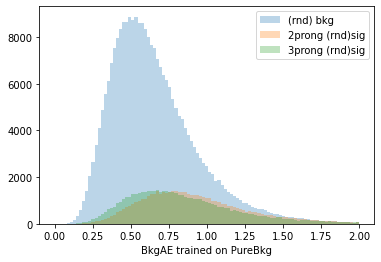

In [63]:
#plt.hist(loss_purebkg,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='Pure Bkg');
plt.hist(loss_rndbkg,bins=np.linspace(0,2,100),density=False,alpha=0.3,label='(rnd) bkg');

plt.hist(loss_prong2,bins=np.linspace(0,2,100),density=False,alpha=0.3,label='2prong (rnd)sig');
plt.hist(loss_prong3,bins=np.linspace(0,2,100),density=False,alpha=0.3,label='3prong (rnd)sig');
#plt.yscale('log')
plt.xlabel('BkgAE trained on PureBkg')
plt.legend(loc='upper right')
#plt.savefig('bkgae_trained_on_purebkg_withmass_turnonselection.png')

In [50]:
ae_def

{'type': 'bkg',
 'trainon': 'purebkg',
 'features': 'tauDDTwithm1andm1minusm2',
 'architecture': 'MAF',
 'selection': 'turnoncutandj1sdbcut',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z6f10'}

In [56]:
len(loss_prong2)

62906

In [328]:
def reconstruct(X):
    out = model(torch.tensor(X[:100000]).float().cuda())[0]
    out = out.data.cpu().numpy()
    return out

In [329]:
out = reconstruct(Y)

In [332]:
out.shape

(56526, 16)

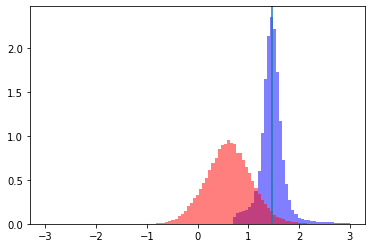

In [336]:
bins = np.linspace(-3,3,100)
bins.shape
column = 0
#print(df.coluns[column])
plt.hist(Y[:,column],bins,density=True,alpha=0.5,color='b');
plt.hist(out[:,column],bins,density=True,alpha=0.5,color='r');
plt.axvline(np.mean(Y[:,column]))

In [97]:
f_bb = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5')

In [98]:
dt = f_bb.values

In [99]:
correct = (dt[:,3]>0) &(dt[:,19]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]
    
for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])
        
        
correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]
Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]

In [100]:
Y.shape

(78233, 24)

In [101]:
idx = dt[:,-1]
sigidx = idx == 1
bkgidx = idx == 0

In [108]:
for i in range(24):
    Y[:,i] = (Y[:,i]-bkg_mean[i])/bkg_std[i]

In [102]:
Y = Y[sigidx]

In [103]:
#correct = Y[:,0] > 300 #(For 2prong)
correct = Y[:,0] > 400 # (for 3prong)

In [104]:
Y = Y[correct]

In [105]:
Y.shape

(58822, 24)

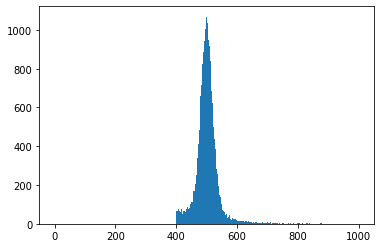

In [106]:
plt.hist(Y[:,0],bins=np.linspace(0,1000,1001));

In [109]:
np.mean(Y[:,0])

2.3954654567608404

In [110]:
total_bb_test = torch.tensor(Y)
bkgae_bbloss = torch.mean((model(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()

In [111]:
bkgae_bbloss

array([0.38415718, 0.4250854 , 0.79621285, ..., 0.53214365, 0.62708235,
       0.52163726], dtype=float32)

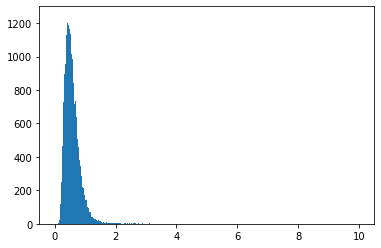

In [112]:
plt.hist(bkgae_bbloss,bins=np.linspace(0,10,1001));

In [113]:
np.save('../data_strings/bkgae_rndbkg_loss_3prong.npy',bkgae_bbloss)

In [52]:
loss_prong3 = np.load('../data_strings/bkgae_purebkg_loss_3prong.npy')
loss_prong2 = np.load('../data_strings/bkgae_purebkg_loss_2prong.npy')
loss_purebkg = np.load('../data_strings/bkgae_purebkg_loss_purebkg.npy')
loss_rndbkg = np.load('../data_strings/bkgae_purebkg_loss_rndbkg.npy')

In [162]:
len(loss_purebkg)

930647

In [117]:
len(loss_prong2)

57042

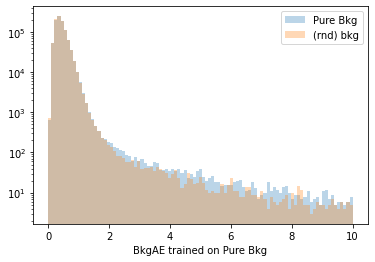

In [63]:
plt.hist(loss_purebkg,bins=np.linspace(0,10,100),weights=np.ones(len(loss_purebkg)),alpha=0.3,label='Pure Bkg');
plt.hist(loss_rndbkg,bins=np.linspace(0,10,100),weights=np.ones(len(loss_rndbkg))*(len(loss_purebkg)/len(loss_rndbkg)),alpha=0.3,label='(rnd) bkg');

#plt.hist(loss_prong3,bins=np.linspace(0,2,100),weights=np.ones(len(loss_prong3))*(len(loss_purebkg)/len(loss_prong3)),alpha=0.3,label='2prong (rnd)sig');
#plt.hist(loss_prong2,bins=np.linspace(0,2,100),weights=np.ones(len(loss_prong2))*(len(loss_purebkg)/len(loss_prong2)),alpha=0.3,label='3prong (rnd)sig');
plt.yscale('log')
plt.xlabel('BkgAE trained on Pure Bkg')
plt.legend(loc='upper right')
plt.savefig('bkgae_trained_on_pure_bkg_onlybkg.png')

In [97]:
def get_loss(dt):
    
    def generator(dt, chunk_size=5000, total_size=1000000):

        i = 0
        i_max = total_size // chunk_size
        print(i_max)
    
        for i in range(i_max):
            start=i * chunk_size
            stop=(i + 1) * chunk_size
            yield torch.tensor(dt[start:stop])
        
    loss = []

    
    with torch.no_grad():
        
        for total_in_selection in generator(dt,chunk_size=5000, total_size=1000000):
            loss.extend(torch.mean((model(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy())
    
    return loss

In [98]:
bb1_loss_bkg = get_loss(X_bb1)

200


In [99]:
bb1_loss_bkg = np.array(bb1_loss_bkg,dtype=np.float)

In [100]:
bb1_loss_bkg

array([0.34203148, 0.20688626, 0.77139115, ..., 0.58295715, 0.60273141,
       0.670748  ])

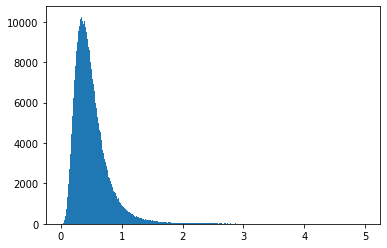

In [101]:
plt.hist(bb1_loss_bkg,bins=np.linspace(0,5,1001));

In [102]:
np.save('../data_strings/bkgaeloss_bb1.npy',bb1_loss_bkg)

In [103]:
f_bb2 = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5')
dt_bb2 = f_bb2.values

In [104]:
X_bb2 = dt_bb2[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [105]:
for i in range(12):
    X_bb2[:,i] = (X_bb2[:,i]-bkg_mean[i])/bkg_std[i]

In [106]:
bb2_loss_bkg = get_loss(X_bb2)

200


In [107]:
bb2_loss_bkg = np.array(bb2_loss_bkg,dtype=np.float)

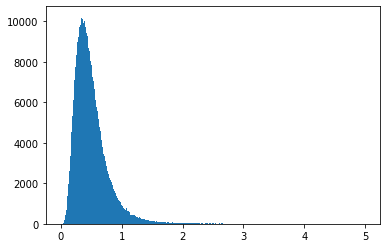

In [108]:
plt.hist(bb2_loss_bkg,bins=np.linspace(0,5,1001));

In [109]:
f_bb3 = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5')
dt_bb3 = f_bb3.values

In [110]:
X_bb3 = dt_bb3[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [111]:
for i in range(12):
    X_bb3[:,i] = (X_bb3[:,i]-bkg_mean[i])/bkg_std[i]

In [137]:
bb3_loss_bkg = get_loss(X_bb3)

200


In [138]:
bb3_loss_bkg = np.array(bb3_loss_bkg,dtype=np.float)

In [139]:
bb3_loss_bkg

array([0.3940129 , 0.36679476, 0.56973112, ..., 0.26589143, 0.32429862,
       0.33480105])

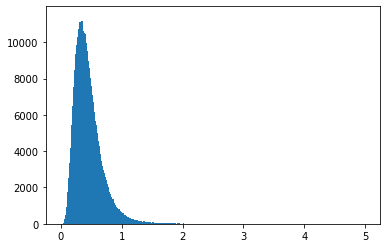

In [140]:
plt.hist(bb3_loss_bkg,bins=np.linspace(0,5,1001));

In [141]:
np.save('../data_strings/bkgaeloss_bb2.npy',bb2_loss_bkg)

In [142]:
np.save('../data_strings/bkgaeloss_bb3.npy',bb3_loss_bkg)

In [24]:
X[signal_idx].shape

(100000, 94)

In [72]:
loss_bkg = get_loss(X[bkg_idx])
loss_sig = get_loss(X[signal_idx])

(992924, 30)
(99829, 30)


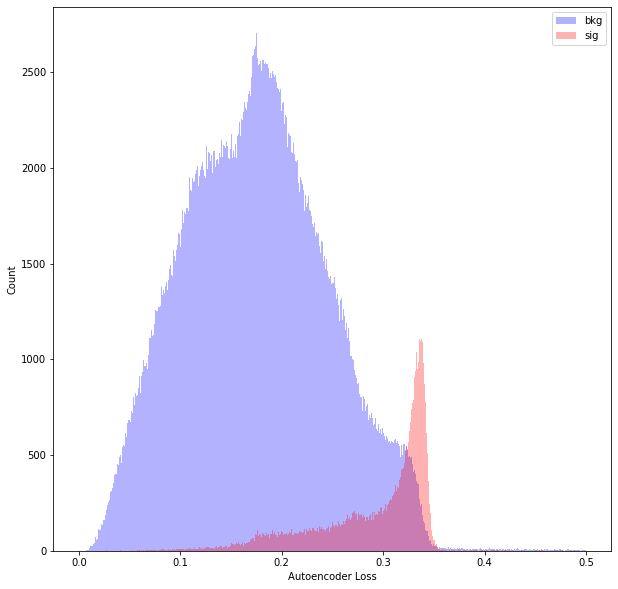

In [74]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(0,0.5,1100)
plt.hist(loss_bkg,bins=bins,alpha=0.3,color='b',label='bkg')
plt.hist(loss_sig,bins=bins,alpha=0.3,color='r',label='sig')
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [ ]:
def get_tpr_fpr(sigloss,bkgloss,aetype='sig'):
    bins = np.linspace(0,50,1001)
    tpr = []
    fpr = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    return tpr,fpr        

In [ ]:
bkg_tpr, bkg_fpr = get_tpr_fpr(loss_sig,loss_bkg,aetype='bkg')

In [ ]:
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)

In [ ]:
plt.plot(bkg_fpr,bkg_tpr,label='Bkg NFlowVAE-Planar')


In [ ]:
def get_precision_recall(sigloss,bkgloss,aetype='bkg'):
    bins = np.linspace(0,100,1001)
    tpr = []
    fpr = []
    precision = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss<cut)[0].shape[0])/(np.where(bkgloss<cut)[0].shape[0]+np.where(sigloss<cut)[0].shape[0]))
            
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss>cut)[0].shape[0])/(np.where(bkgloss>cut)[0].shape[0]+np.where(sigloss>cut)[0].shape[0]))
    return precision,tpr      

In [ ]:
precision,recall = get_precision_recall(loss_sig,loss_bkg,aetype='bkg')

In [ ]:
np.save('NFLOWVAE_PlanarNEW_22var_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_22var_bkgloss.npy',loss_bkg)

In [ ]:
np.save('NFLOWVAE_PlanarNEW_precision.npy',precision)
np.save('NFLOWVAE_PlanarNEW_recall.npy',recall)
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)
np.save('NFLOWVAE_PlanarNEW_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_bkgloss.npy',loss_bkg)

In [ ]:
plt.plot(recall,precision)

In [ ]:
flows = [1,2,3,4,5,6]
zdim = [1,2,3,4,5]

for N_flows in flows:
    for Z_DIM in zdim:
        model = VAE_NF(N_FLOWS, Z_DIM).cuda()
        optimizer = optim.Adam(model.parameters(), lr=LR)
        BEST_LOSS = 99999
        LAST_SAVED = -1
        PATIENCE_COUNT = 0
        PATIENCE_LIMIT = 5
        for epoch in range(1, N_EPOCHS):
            print("Epoch {}:".format(epoch))
            train()
            cur_loss = evaluate()

            if cur_loss <= BEST_LOSS:
                PATIENCE_COUNT = 0
                BEST_LOSS = cur_loss
                LAST_SAVED = epoch
                print("Saving model!")
                if mode == 'ROC':
                    torch.save(model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_RND_22var_z{Z_DIM}_f{N_FLOWS}.h5")
                else:
                    torch.save(model.state_dict(), f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_PureBkg_22var_z{Z_DIM}_f{N_FLOWS}.h5")
            else:
                PATIENCE_COUNT += 1
                print("Not saving model! Last saved: {}".format(LAST_SAVED))
                if PATIENCE_COUNT > 3:
                    print("Patience Limit Reached")
                    break 
                    
        loss_bkg = get_loss(dt_PureBkg[bkg_idx])
        loss_sig = get_loss(dt_PureBkg[signal_idx])
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_sigloss.npy',loss_sig)
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_bkgloss.npy',loss_bkg)